In [72]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

# Loading names.txt

In [73]:
words = open('data/names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

# "str to int" and "int to str"

In [74]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


# Buidling Test, Dev, Train datasets

In [75]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


# Batch norm Reasoning

tensor(0.0089) tensor(1.0041)
tensor(-0.0030) tensor(1.0222)


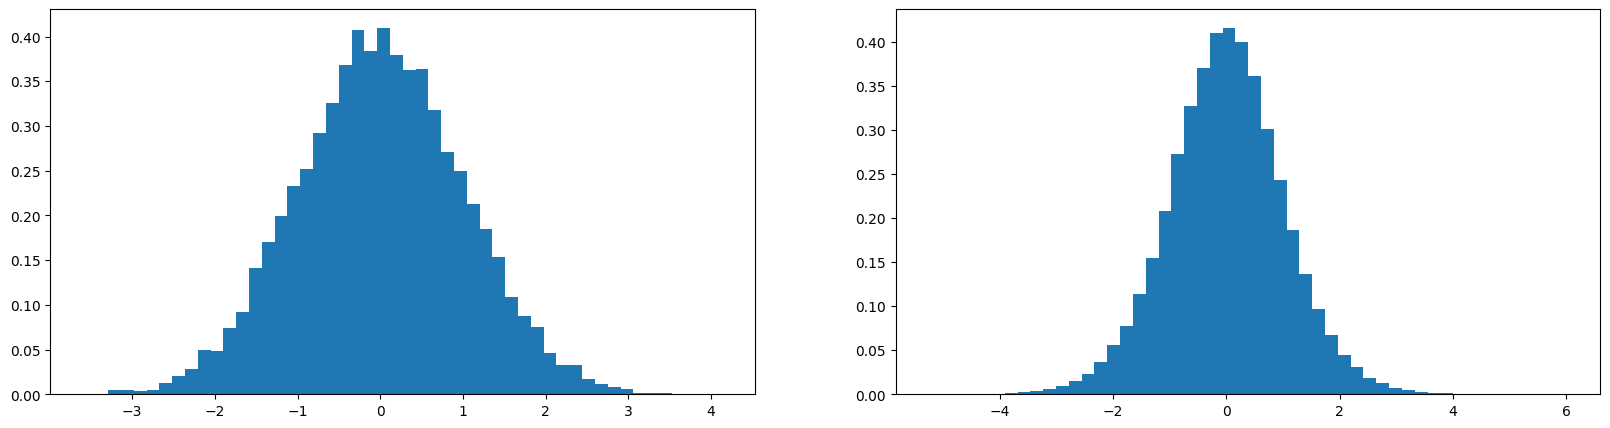

In [76]:
x = torch.randn(1000,10)
w = torch.randn(10, 200)/ 10**0.5

y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(),50,density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(),50,density=True);

# Neural Network Architecture

In [77]:
n_emb = 10
n_hidden = 200
vocab_size = len(stoi)

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_emb),           generator=g)
W1 = torch.randn((n_emb*block_size, n_hidden),  generator=g) * (5/3)/(n_emb*block_size)**0.5   #faning for tanh is 5/3 
b1 = torch.randn(n_hidden,                      generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),        generator=g) * 0.01
b2 = torch.randn(vocab_size,                    generator=g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))


parameters = [C, W1, b1, W2, b2, bngain,bnbias]

print(sum(p.nelement() for p in parameters)) # number of parameters in total

for p in parameters:
  p.requires_grad = True

lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre
lri = []
lossi = []
stepi = []

12297


# Training Neural Network

In [78]:

max_steps = 200000
batch_size = 32
lossi = []


for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  hpreact = embcat @ W1 + b1

  with torch.no_grad():
    bnmean_running = 0.999*bnmean_running + 0.001*bnmeani
    bnstd_running = 0.999*bnstd_running + 0.001*bnstdi

  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi = hpreact.std(0, keepdim=True)
  hpreact = bngain*(hpreact-bnmeani)/bnstdi + bnbias

  h = torch.tanh(hpreact)
  logits = h @ W2 + b2 
  loss = F.cross_entropy(logits, Yb)
  #print(loss.item())
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  #lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  if i % 10000 == 0:
    print(f'{i:2d}/{max_steps:7d}: {loss.item():4f}')
  lossi.append(loss.log10().item()) 

 0/ 200000: 3.314689
10000/ 200000: 2.198444
20000/ 200000: 2.337455
30000/ 200000: 2.435885
40000/ 200000: 2.011928
50000/ 200000: 2.259472
60000/ 200000: 2.477499
70000/ 200000: 2.102000
80000/ 200000: 2.278813
90000/ 200000: 2.186206
100000/ 200000: 1.947382
110000/ 200000: 2.301028
120000/ 200000: 1.983653
130000/ 200000: 2.452321
140000/ 200000: 2.383933
150000/ 200000: 2.198679
160000/ 200000: 1.973300
170000/ 200000: 1.866809
180000/ 200000: 1.997270
190000/ 200000: 1.834683


# Loss over iterations

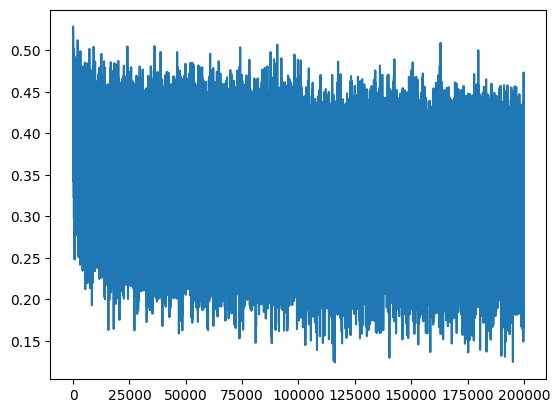

In [79]:
plt.plot(lossi)

In [80]:
with torch.no_grad():
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

# Neural Network Evaluation 

In [81]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr,Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    #hpreact = bngain*(hpreact-hpreact.mean(0, keepdim=True))/hpreact.std(0, keepdim=True) + bnbias
    hpreact = bngain * (hpreact-bnmean_running)  /bnstd_running + bnbias

    h  = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split,loss.item())

split_loss('train')
split_loss('val')

train 2.066592216491699
val 2.105053663253784


# Sampling From The Trained Model 

In [82]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

carpahzarbriq.
shlimrixtts.
lusslaysierricnenddhn.
frtivgqliyah.
farrichaiirdnsleggyu.
bmanvitte.
sants.
lustvi.
vabbuwatth.
giidryxiidh.
sulipsables.
falia.
gtas.
jasfaylahas.
bduricsydustquovozswy.
bjumillassannyks.
sadlusoffordst.
sramsryndlycpllmanraq.
shelseombriyabhda.
ffxrdustvebndvi.
